In [38]:
import pandas as pd
import numpy as np
import pylab as plt
import segyio
import SegRead as s
import os
import sys
from seislab.src import segyrw 
from seislab.src import plot_seismic
from LAS import Converter
from scipy import signal
from scipy.signal import medfilt
import laspy
from sklearn.linear_model import LinearRegression
from docx import Document
from numpy.linalg import solve
from matplotlib.colors import Normalize
from laspy.file import File
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# функция сглаживания в разработке, не используется
def edge_preserving_smooth(sgn,win):
    win_len = win
    o = 0
    signal = sgn.copy()
    for i in np.arange(len(signal)):
        if i < win_len-1:
            o += 1
            pass
        elif i > len(signal)-win_len:
            pass
        else:
            I = []
            Ind1 = []
            Ind2 = []
            std = []
            for j in np.arange(win):
                ind1 = i+j-o
                ind2 = i+j+win_len-o
                I.append(i)
                Ind1.append(ind1)
                Ind2.append(ind2)
                std.append(np.std(signal[ind1:ind2]))
            df = pd.DataFrame({'i':I,'std':std,'ind1':Ind1,'ind2':Ind2})
            b = df.groupby('i')['std'].idxmin()
            b1 = int(df['ind1'][b.values].values)
            b2 = int(df['ind2'][b.values].values)
            signal[i] = signal[b1:b2].mean()
    return signal

# поворот фазы сигнала
def ifft_with_phase(F, x, phase):
    sign = np.ones(len(x))
    sign[np.where(x<0)] = -1*sign[np.where(x<0)]
    sign[np.where(x==0)] = 0
    F_new = np.abs(F)*np.exp(-1j*(np.angle(F)+sign*phase))
    Finv = np.fft.ifft(F_new)
    return np.real(Finv)

# расчет огибающей сигнала
def envelope_calc(Finv):
    hilbert_signal = np.imag(signal.hilbert(Finv))
    envelope = np.sqrt(Finv*Finv+hilbert_signal*hilbert_signal)
    return envelope

## STACK [.sgy]


In [40]:

directory = ''

In [41]:
class SeismicData():
    def __init__(self,path):
        self.ss = s.Seg.SegReader()
        self.ss.open(path)
        
        data,head=self.ss.get_data_and_trace_heads()
        self.data=data.T
        self.head=head
        self.dt = self.ss.get_dt()/1000# Дискретизация (считывать из хэдеров?)!!!!2 или 2000!!!
        self.Tdata =np.arange(0,np.shape(self.data)[0]*self.dt,self.dt)/1000
    def get_offset(self,lasData):
        self.offsets=np.zeros(len(self.head['CDP_X']))
        for ii in range(0, len(self.head['CDP_X'])):
            self. offsets[ii]=np.sqrt((lasData.well_X-self.head['CDP_X'][ii])*(lasData.well_X-self.head['CDP_X'][ii])+(lasData.well_Y-self.head['CDP_Y'][ii])*(lasData.well_Y-self.head['CDP_Y'][ii]))
        return self.offsets
    
    def get_Seism_sig(self,T_well):
        Seism_sig=np.interp(T_well,self.Tdata,np.squeeze(self.data[:,a[0]]))
        return Seism_sig

In [42]:
#прикрутить свою библиотеку

filename = directory+'307_Stk_w1.sgy'
seismicData=SeismicData(filename)

  # вектор врмеен для сейсмики

In [43]:
%matplotlib notebook
%matplotlib inline

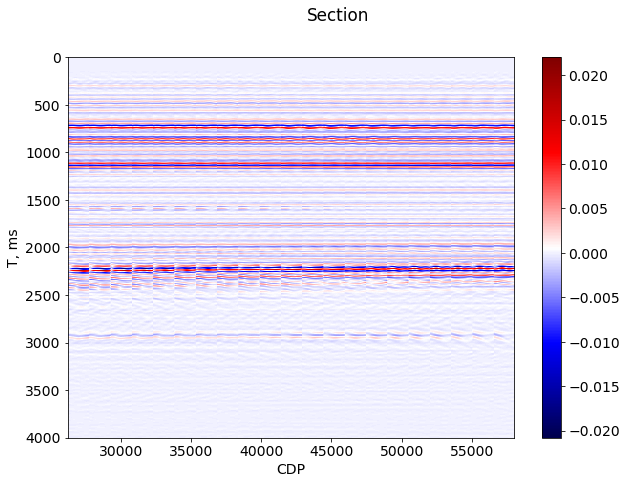

In [44]:


plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(figsize = (10,7))
cs = axs.imshow(seismicData.data,aspect = 'auto',extent = [seismicData.head['CDP_TRACE'].min(),seismicData.head['CDP_TRACE'].max(),
                                                                 seismicData.dt*seismicData.data.shape[0],0],cmap='seismic')
cs2 = axs.imshow(seismicData.data,aspect = 'auto',extent = [seismicData.head['CDP_TRACE'].min(),seismicData.head['CDP_TRACE'].max(),
                                                                 seismicData.dt*seismicData.data.shape[0],0],cmap='seismic')
# ,vmin = -2.5,vmax = 2.5
axs.set_xlabel('CDP')
axs.set_ylabel('T, ms')
fig.suptitle('Section')
fig.colorbar(cs, ax=axs)


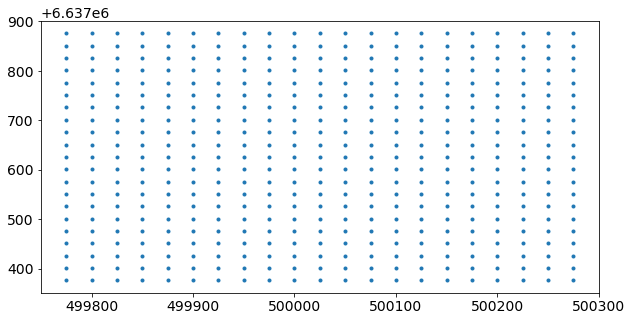

In [45]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(seismicData.head['CDP_X'],seismicData.head['CDP_Y'],linewidth = 0,marker='.')

In [46]:
class WellData():
    def __init__(self,path,data=None,params=None,del_invalid=False,invalid_columns=None,invalid_value=None):
        c= Converter()
        log = c.set_file(path)
        params_l=log.parameter

        if(params!=None):
            self.heads={}
            for key,value in params.items():
                self.__dict__[value] =params_l[key]['value']
                self.heads[value]= self.__dict__[value]
            print(self.heads)
            self.heads=pd.DataFrame(self.heads,index=[0])
        
        if(data!=None):
            self.data={}
            for key,value in data.items():
                self.__dict__[value] =log.data[key]
                self.data[value]=self.__dict__[value]     
            self.data=pd.DataFrame(self.data)
            
            if(del_invalid):
                self.data=self.data.dropna()
    
    def convert_to_df_head(self):
        return self.heads
    def convert_to_df_data(self):
        return self.data
    def convert_to_df(self,including=None,excluding=None):
        if(including):
                newdict={}
                for i in including:
                    newdict[i]=self.__dict__[i]
                return  pd.DataFrame(newdict)
        if(excluding):
                newdict={}
                for key,value in self.__dict__.items() :
                    if(key in excluding):
                        continue
                    else:
                        newdict[key]=value
                return  pd.DataFrame(newdict)
            
            
        return pd.DataFrame(self.__dict__)
    def merge(self,well,left_on,right_on):
        well_res=self.data.merge(well,left_on=left_on, right_on=right_on)
        self.data=well_res
        return self.data
    def set_reflectivity(self,params):
        self.data['Reflectivity']=0.0

        for ii in range(0,len(self.data['Time'])-1):
            self.data['Reflectivity'][ii]=((1/self.data[params[0]][ii])*self.data[params[1]][ii]-(1/self.data[params[0]][ii+1])*self.data[params[1]][ii+1])/((1/self.data[params[0]][ii])*self.data[params[1]][ii]+(1/self.data[params[0]][ii+1])*self.data[params[1]][ii+1])
    def get_Refl_int(self,T_well):
        self.Refl_int=np.interp(T_well,self.data['Time'],self.data['Reflectivity'])
        return self.Refl_int

## WELL [.las]

In [47]:

wellData=WellData(path= "Z-Zim-1_TIME.las",
                params={"XCRD":"well_X","YCRD":"well_Y"},
                data={"depth":"Depth","tvdss":"TVDSS","time":"Time"})
    
well = wellData.convert_to_df_data()

{'well_X': 500001.0, 'well_Y': 6637623.6}


In [48]:
well

,Depth,TVDSS,Time
0,74.9808,29.5506,0.060438
1,75.1332,29.7030,0.060608
2,75.2856,29.8554,0.060778
3,75.4380,30.0078,0.060948
4,75.5904,30.1602,0.061118
...,...,...,...
19550,3054.4008,3008.0134,2.402797
19551,3054.5532,3008.1651,2.402863
19552,3054.7056,3008.3168,2.402928
19553,3054.8580,3008.4685,2.402994


In [49]:
offsets=seismicData.get_offset(wellData) 

a=np.where(offsets<=np.min(offsets))
offsets_sort=np.argsort(offsets)

offsets[offsets_sort[0:10]]

array([  2.6       ,  22.62211308,  24.11970149,  26.11053427,
        27.4182421 ,  32.96604314,  34.44938316,  36.42471688,
        37.77247675,  47.61050304])

In [50]:
# считка данных со скважины (использовать библиотеку ИТСК)

wellData2=WellData("Z-Zim-1jgw.las",data={"depth":"Depth_T","tvd":"TVD","tvdss":"TVDSS","dx":"DX",
                                        "dy":"DY","dts":"DTS","dt":"DT","rhob":"RHOB"},
                    del_invalid=True)

well_T = wellData2.convert_to_df_data()

In [51]:
well_T

,Depth_T,TVD,TVDSS,DX,DY,DTS,DT,RHOB
5643,1018.9464,1018.9257,973.4957,2.733678,3.587893,0.000882,0.000413,2189.6578
5644,1019.0988,1019.0781,973.6481,2.734593,3.588198,0.000897,0.000420,2194.1760
5645,1019.2512,1019.2305,973.8005,2.735507,3.588503,0.000933,0.000428,2184.1757
5646,1019.4036,1019.3829,973.9529,2.736422,3.588807,0.000990,0.000438,2151.1944
5647,1019.5560,1019.5353,974.1053,2.737336,3.589112,0.001006,0.000448,2119.7405
...,...,...,...,...,...,...,...,...
18961,3048.6096,3047.6784,3002.2484,24.185295,10.054864,0.000499,0.000247,2413.7525
18962,3048.7620,3047.8301,3002.4001,24.183618,10.068580,0.000499,0.000249,2460.0000
18963,3048.9144,3047.9819,3002.5519,24.181942,10.082296,0.000499,0.000250,2460.0000
18964,3049.0668,3048.1337,3002.7037,24.180265,10.096012,0.000499,0.000250,2460.0000


In [52]:
well=wellData.merge(well_T,left_on="Depth",right_on='Depth_T')
wellData.set_reflectivity(params=["DT","RHOB"])

In [53]:
wellData.convert_to_df_data()

,Depth,TVDSS_x,Time,Depth_T,TVD,TVDSS_y,DX,DY,DTS,DT,RHOB,Reflectivity
0,1018.9464,973.4957,1.056899,1018.9464,1018.9257,973.4957,2.733678,3.587893,0.000882,0.000413,2189.6578,0.007999
1,1019.0988,973.6481,1.057036,1019.0988,1019.0781,973.6481,2.734593,3.588198,0.000897,0.000420,2194.1760,0.011334
2,1019.2512,973.8005,1.057174,1019.2512,1019.2305,973.8005,2.735507,3.588503,0.000933,0.000428,2184.1757,0.019443
3,1019.4036,973.9529,1.057312,1019.4036,1019.3829,973.9529,2.736422,3.588807,0.000990,0.000438,2151.1944,0.018529
4,1019.5560,974.1053,1.057450,1019.5560,1019.5353,974.1053,2.737336,3.589112,0.001006,0.000448,2119.7405,0.007654
...,...,...,...,...,...,...,...,...,...,...,...,...
13318,3048.6096,3002.2484,2.400263,3048.6096,3047.6784,3002.2484,24.185295,10.054864,0.000499,0.000247,2413.7525,-0.006307
13319,3048.7620,3002.4001,2.400332,3048.7620,3047.8301,3002.4001,24.183618,10.068580,0.000499,0.000249,2460.0000,0.001900
13320,3048.9144,3002.5519,2.400401,3048.9144,3047.9819,3002.5519,24.181942,10.082296,0.000499,0.000250,2460.0000,0.000704
13321,3049.0668,3002.7037,2.400470,3049.0668,3048.1337,3002.7037,24.180265,10.096012,0.000499,0.000250,2460.0000,0.000000


In [54]:
class plot_data():#Класс для хранения данных (новое название)
    def __init__(self,x,y,color=None,linewidth=2,label=None):
        #x,y - данные
        #color - цвет
        #label = метка
        #Те же данные, что передаются в plot(x,y,color,lineidth,label)
        self.x=x
        self.y=y
        self.color=color
        self.linewidth = linewidth
        self.label=label
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    def get_color(self):
        return self.color
    
    def get_linewidth(self):
        return self.linewidth
    
    def get_label(self):
        return self.label
        

class sub_fig():#Класс отвечающий за один график на канвасе аналог axs[i]
    
    def __init__(self,plots_data=[],#plots_data - Список классов для даты[plot_data_1(),plot_data_2()...]
                 x_lim=[],#[min,max] по x
                 y_lim=[],#[min,max] по y
                 x_label="X",#-меткa по x
                 y_label="Y",#меткa по y
                 title="title",#title
                 fontsize=14,
                 linestyle="-"):#ширина 14
        
        self.plot_data=plots_data
        self.x_label=x_label
        self.y_label=y_label
        self.title=title
        self.fontsize=14
        self.x_lim=x_lim
        self.y_lim=y_lim
        self.linestyle=linestyle
        
    def get_title(self):
        return self.title
           
    def get_fontsize(self):
        return self.fontsize
           
    def get_plot_data(self):
        return self.plot_data
           
    def get_y_label(self):
        return  self.y_label
           
    def get_x_label(self):
        return   self.x_label
    
    def get_y_lim(self):
        return  self.y_lim
           
    def get_x_lim(self):
        return   self.x_lim
    def get_linestyle(self):
        return self.linestyle
    
#Тип линии для каждой data
def paint_subplots(nrows=None,ncols=None,figsize=None,layers=[],wspace=0.7,hspace=0.7):
    if(not nrows or not ncols or (nrows==1 and ncols==1)):
        fig,axs = plt.subplots(figsize=figsize,constrained_layout=True)
        axs.plot(layers[0].get_plot_data()[0].get_x(),layers[0].get_plot_data()[0].get_y(),color=layers[0].get_plot_data()[0].get_color(),
                        linewidth=layers[0].get_plot_data()[0].get_linewidth(),label=layers[0].get_plot_data()[0].get_label(),linestyle=layers[0].get_linestyle())
        if(len(layers[0].get_y_lim())>0):
            axs.set_ylim(layers[0].get_y_lim()[0],layers[0].get_y_lim()[1])
        if(len(layers[0].get_x_lim())>0):
            axs.set_xlim(layers[0].get_x_lim()[0],layers[0].get_x_lim()[1])
        axs.set_ylabel(layers[0].get_y_label())
        axs.set_xlabel(layers[0].get_x_label());
        axs.set_title(layers[0].get_title())
        return
        
        
    fig,axs = plt.subplots(nrows,ncols,figsize=figsize,constrained_layout=True)
    for i in range(len(layers)):
        for j in range(len(layers[i].get_plot_data())):
            if(len(layers[i].get_y_lim())>0):
                axs[i].set_ylim(layers[i].get_y_lim()[0],layers[i].get_y_lim()[1])
            if(len(layers[i].get_x_lim())>0):
                axs[i].set_xlim(layers[i].get_x_lim()[0],layers[i].get_x_lim()[1])

            axs[i].set_ylabel(layers[i].get_y_label())
            axs[i].set_xlabel(layers[i].get_x_label());
            axs[i].plot(layers[i].get_plot_data()[j].get_x(),layers[i].get_plot_data()[j].get_y(),color=layers[i].get_plot_data()[j].get_color(),
                        linewidth=layers[i].get_plot_data()[j].get_linewidth(),label=layers[i].get_plot_data()[j].get_label(),linestyle=layers[0].get_linestyle())

  
        axs[i].set_title(layers[i].get_title())
        plt.subplots_adjust(wspace=wspace,hspace=hspace)


<ipython-input-55-b61ee86417b5>:10: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_2_2= plot_data(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')
<ipython-input-54-db6958e39a58>:102: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


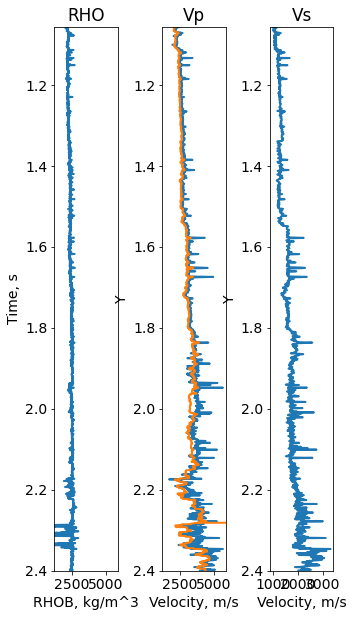

In [55]:
# визуализация скважинных данных от времени (плотность, скорость Вп по акустике/скорость Вп по закону H(T0), скорость Вс)
#че с осями
#Сперва готовим данные, что буди отображать на графике. 1 класс plot_data, грубо говоря, отвечает за одну линию на графике
plotdata_1= plot_data(well['RHOB'],#data x
                      well['Time'],#data y
                      linewidth = 2
                     )
#Допустим на графике по середине две линии plotdata_2_1 и plot_data_2_2
plotdata_2_1= plot_data(1/well['DT'],well['Time'],linewidth = 2,label='V_DT')
plotdata_2_2= plot_data(2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_H(T0)')

plotdata_3=plot_data(1/well['DTS'],well['Time'],linewidth = 2)

layers=[]
#sub_fig(plot_data,...)- один график 
#У нас их три по этому sub_fig() тоже 3
#Один sub_fig опиывает один график
layers.append(sub_fig([plotdata_1],#data
                      y_lim=[well['Time'].max(),well['Time'].min()],#limits
                      x_label="RHOB, kg/m^3",#x label
                      y_label="Time, s",#y label
                      title="RHO",#title
                      x_lim=[1200,5900]
                     ))
layers.append(sub_fig([plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[1200,5900],title="Vp",x_label="Velocity, m/s"))
layers.append(sub_fig([plotdata_3],y_lim=[well['Time'].max(),well['Time'].min()],x_label='Velocity, m/s',title="Vs"))        
#Передаём количество графиков (1 строка 3 ряда), размер фигуры, слои
paint_subplots(1,3,figsize = (5,10),layers=layers)

<ipython-input-56-f159a94ce190>:3: RuntimeWarning: divide by zero encountered in true_divide
  plotdata_1=plot_data(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')
<ipython-input-56-f159a94ce190>:4: RuntimeWarning: divide by zero encountered in true_divide
  dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])
<ipython-input-54-db6958e39a58>:102: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=wspace,hspace=hspace)


inf

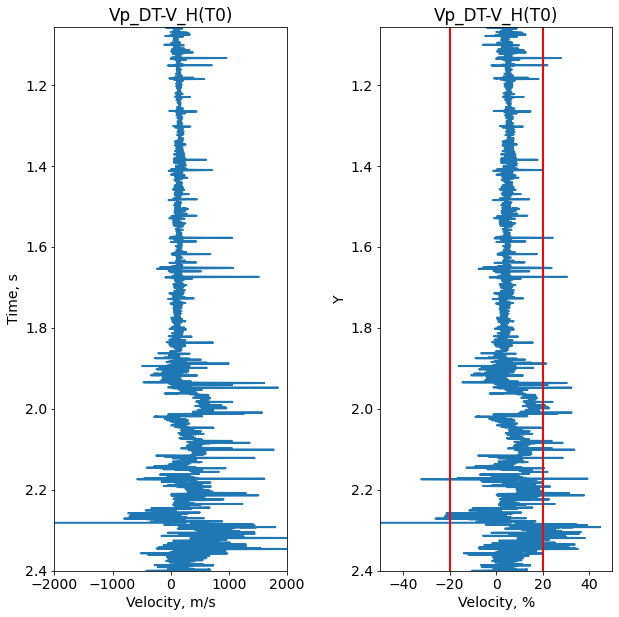

In [56]:
# визуализация разницы скоростей по акустике, по H(T0)

plotdata_1=plot_data(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']),well['Time'][1:],linewidth = 2,label='V_DT')
dV_otn=(1/well['DT'][1:]-2*np.diff(well['Depth'])/np.diff(well['Time']))*100/(1/well['DT'][1:])
plotdata_2=plot_data(dV_otn,well['Time'][1:],linewidth = 2,label='dV_%')
plotdata_2_1=plot_data([-20, -20],[well['Time'].max(), well['Time'].min()],color='r')
plotdata_2_2=plot_data([20, 20],  [well['Time'].max(), well['Time'].min()],color='r')
layers=[]
layers.append(sub_fig([plotdata_1],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-2000,+2000],x_label='Velocity, m/s',y_label="Time, s",title="Vp_DT-V_H(T0)"))
layers.append(sub_fig([plotdata_2,plotdata_2_1,plotdata_2_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-50,50],x_label='Velocity, %',title="Vp_DT-V_H(T0)"))
paint_subplots(1,2,figsize = (10,10),layers=layers,wspace=0.4)    
np.max(abs(dV_otn))

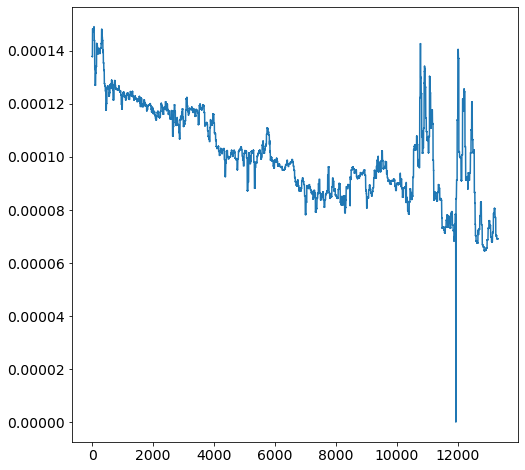

In [21]:
fig,axs = plt.subplots(figsize = (8,8))
axs.plot(np.diff(well['Time']))

In [22]:
# расчет коэффициентов отржаения по скважине (через Вп и плотность)
# вектор времен для данных со скважины (определять dt по среденему dt из закона H(T0))

T_well=np.arange(seismicData.Tdata[0],seismicData.Tdata[-1],0.0001)

Seismig_sig=seismicData.get_Seism_sig(T_well)
Refl_int=wellData.get_Refl_int(T_well)


In [23]:
a

(array([219], dtype=int64),)

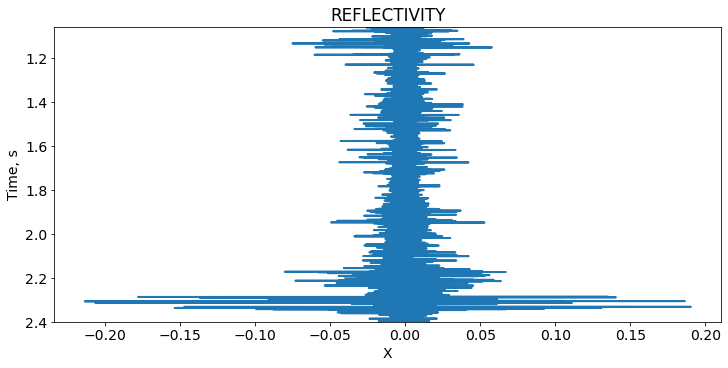

In [24]:
# визуализация коэффициентов отржажения
layers=[]
plot_data_1=plot_data(well['Reflectivity'],well['Time'],linewidth = 2)

layers.append(sub_fig([plot_data_1],y_lim=[well['Time'].max(),well['Time'].min()], y_label="Time, s",title="REFLECTIVITY"))
paint_subplots(figsize = (10,5),layers=layers,wspace=0.4)


In [25]:
class Impulse():
    def __init__(self,path,start,stop,dt):
        with open(path,"r") as file:
            i=0
            flag=False
            for line in file:
                if(line[0:2]=='"*'):
                    continue
                else:break
            self.info=line
            self.start_time_or_depth=float(file.readline())
            self.sample_interval=float(file.readline())
            self.N = int(file.readline())
            self.data=np.array( [float(i) for i in list(file)])
            self.T=np.arange(self.start_time_or_depth,self.start_time_or_depth+(self.N)*self.sample_interval,self.sample_interval)
            # вектор времен с дискретизацией по скважине и дополнение нулями для норм спектров
            self.T_int2=np.arange(start,stop,dt) 
            self.Sig=np.interp(self.T_int2,self.T,self.data)
    def get_params():
        return self.T_int2,self.Sig


## Impulse [.xls]

In [26]:

imp = Impulse("Multi_wavelets.csv",-0.2,0.2,0.0001)



In [27]:
Seismig_sig

array([  3.52177995e-06,   3.61845223e-06,   3.71512451e-06, ...,
         5.20504155e-05,   5.45031878e-05,   5.69559601e-05])

Text(0.5, 1.0, 'Signal')

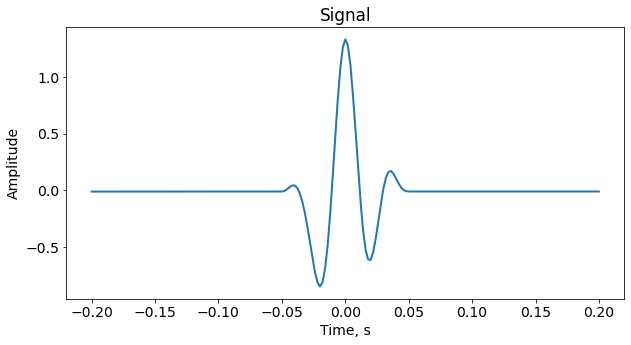

In [28]:
# визуализация сигнала

fig,axs = plt.subplots(figsize = (10,5))
axs.plot(imp.T_int2,imp.Sig,linewidth = 2)

axs.set_xlabel('Time, s')
axs.set_ylabel('Amplitude');
axs.set_title('Signal')

## Расчет метрик

In [29]:
# осреднение данных по сейсмике для нормальных спектров (нужно в каком то радиусе, тут для всей сейсмики)

Seism_sig_mean=np.zeros(np.shape(seismicData.data)[0])
for ii in range(0,np.shape(seismicData.data)[0]):
    Seism_sig_mean[ii]=np.mean(seismicData.data[ii,:])


Seism_sig_mean=np.interp(T_well,seismicData.Tdata,Seism_sig_mean)
    
# выделение целевого интервала (это входной параметр для всего инструмента)

Seism_sig_mean[0:10000]=0
Seism_sig_mean[24000:-1]=0

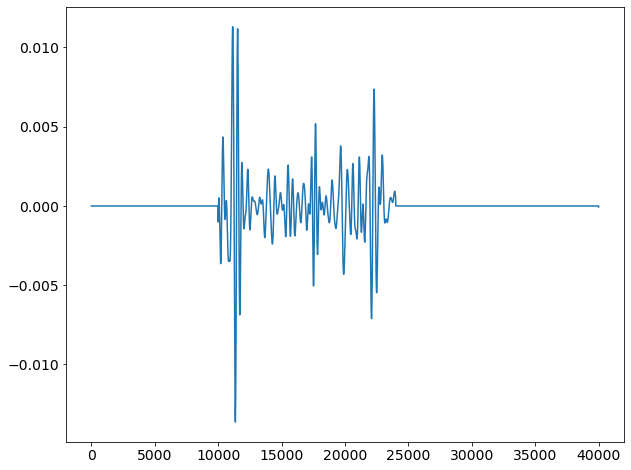

In [30]:
# визуализация осредненной трассы по сейсмике

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(Seism_sig_mean)

In [31]:
def intersection_point(x_2,f,g):
    
   
    first_line = LineString(np.column_stack((x_2, f)))
    second_line = LineString(np.column_stack((x_2, g)))
    intersection = first_line.intersection(second_line)
    x_1,y_1=LineString(intersection).xy
    x_1=np.array(x_1).reshape(len(np.array(x_1)),1)
    y_1=np.array(y_1).reshape(len(np.array(y_1)),1)
    return  x_1,y_1

In [32]:
def diff_1__3__2(x,ind2,ind3):
    return x[ind3]-x[ind2]



In [33]:

def Pha(x,z):
    
    ind = np.squeeze(np.where(x>0))
    x=x[ind]
    ind2 = np.squeeze(np.where(x<=60))#x.max x.min<=x[ind]<=x.max
    x_apr = x[ind2]#0..60
    reg1 = LinearRegression().fit(x_apr.reshape(-1, 1), z[ind[ind2]].reshape(-1, 1))
    z_apr = reg1.coef_*x_apr.reshape(-1, 1)+reg1.intercept_
    z_apr_extr=reg1.intercept_[0]

    Phase=np.round(z_apr_extr,2)#фаза
    A=(np.round(reg1.coef_[0][0],3))#Наклоны
    
    return Phase,A

In [34]:

def Freq(x,F):
 
    
    f=np.max(F)*np.ones(np.shape(x))*0.2
    g=np.abs(F)
    
    x_1,y_1= intersection_point(x,f,g)
    points=np.concatenate([x_1,y_1],axis=1)
    
    x_max=[0,0]
    x_min=[0,0]
    
    for a,b in points:
        if(np.abs(a-pt[0])>first_p[0]):
            x_max=[a,b]
    for a_1,b_1 in points:
        if(np.abs(a_1-pt[0])>second_p[0] and a_1!= first_p[0]):
            x_min=[a_1,b_1]        

    print(x_max,x_min)
    ind = np.squeeze(np.where(x>0))#>=0
    x=x[ind]
    F=F[ind]
    z=np.angle(F)
   
 

    ind2 = np.argmax(np.abs(F))#Доминантная частота сигнала(максимум графика)(index)
#     ind3 = np.squeeze((np.where(np.abs(F)<np.abs(F[ind2])*20/100)))#20% от максимума графика
    
    Dom=x[ind2]#Доминантная частота сигнала
    Ampl_Dom=F[ind2]#Амплитуда доминантной частоты
    Width=(x_max[0]-x_min[0])#Ширина колокола
    
    
    return Dom,Ampl_Dom,x_min[0],x_max[0],Width

In [35]:
#Новая версия страшного блока

from scipy import spatial


dt=0.0001
F = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(imp.Sig)))
x = np.fft.ifftshift(np.fft.fftfreq(len(imp.Sig),dt))#Частоты

z=np.angle(F)
Dom,Ampl_Dom,x_min,x_max,Width=Freq(x,F)

Phase,A=Pha(x,z)

dt=0.0001
F2 = np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(Seismig_sig)))
x2 = np.fft.ifftshift(np.fft.fftfreq(len(Seismig_sig),dt))
Dom2,Ampl_Dom2,x_min_2,x_max_2,Width=Freq(x2,F2)



ind = np.squeeze(np.where(x>0))#>=0

f=np.max(F)*np.ones(np.shape(x))*0.2
g=np.abs(F)
plotdata_1=plot_data(x,f,color='orange')
plotdata_2=plot_data(x,g,label = 'Signal_well')


plotdata_3=plot_data(x,z)
layers=[]
layers.append(sub_fig([plotdata_1,plotdata_2],x_lim=[0,100],x_label='Freaquency, s',y_label="Amplitude",linestyle="--",title='Ampl_spectre, min_s = ' + str(x_min) + ', max_s = ' + str(x_max) + ', min_seis = ' + str(x_min_2) + ', max_seis = ' + str(x_max_2)))
layers.append(sub_fig([plotdata_3],x_lim=[0,100],x_label='Freaquency, Hz',title="Phase_spectre"))
paint_subplots(2,1,figsize = (10,8),layers=layers,wspace=0.7)   

   

NameError: name 'LineString' is not defined

In [ ]:
np.array([[1,0,1,0,0,1],[1,1,0,1,0,1], [1,1,0,0,1,0]]).T


In [ ]:
# СВЕРТКА СИГНАЛА И КОЭФФИЦИЕНТОВ ОТРАЖЕНИЯ
print(imp.Sig)
print(Refl_int)
res=np.convolve(Refl_int, imp.Sig, mode='same')
# res2=np.convolve(Refl_int, signal, mode='same')

In [ ]:
# визуализация ближней к скважине сейсмической трассы, свертки из прошлого блока, коэффициентов отражения


plotdata_1=plot_data(Seismig_sig,T_well,linewidth = 2)
plotdata_2=plot_data(res,T_well,linewidth = 2)
plotdata_3=plot_data(Refl_int,T_well,linewidth = 2,color = 'k')

layers=[]

layers.append(sub_fig([plotdata_1],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-0.02,0.02],y_label="Time, s",title="Sesmic"))
layers.append(sub_fig([plotdata_2],y_lim=[well['Time'].max(),well['Time'].min()],x_lim=[-0.3,0.3],title="Synt_Signal"))
layers.append(sub_fig([plotdata_3],y_lim=[well['Time'].max(),well['Time'].min()],title="Коэф. отраж"))

paint_subplots(1,3,figsize = (10,10),layers=layers,wspace=0.4)    


In [ ]:
# ФВК трассы сейсмики(не осредненной) и скважины, расчет метрик 

fig,axs = plt.subplots(figsize = (10,4))
Seism_sig2=Seism_sig.copy()
res2=res.copy()
Seism_sig2[0:10000]=0 # выделение целевого интервала
Seism_sig2[24000:-1]=0
res2[0:10000]=0
res2[22500:-1]=0

resC=np.correlate(Seism_sig2, res2, mode='full')
resC=resC/(np.std(Seism_sig2)*np.std(res2)*len(res2))
resE=envelope_calc(resC)

KK0=(np.mean(Seism_sig2*res2)-np.mean(Seism_sig2)*np.mean(res2))/(np.std(res2)*np.std(Seism_sig2))
KK=resC[np.argmax(np.abs(resC))]
KKdt=np.argmax(resC)-len(res2)+1
Edt=np.argmax(resE)-len(res2)+1


print(KK)
print(KKdt)
print(Edt)

axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resC)
axs.plot(np.arange(-len(res2)+1,len(res2),1)*0.0001,resE)
axs.set_xlim(-0.4,0.4)
axs.set_title('FVK 1-2.4s, KK = ' + str(np.round(KK0,2)) + ', KK_max = ' + str(np.round(KK,2)) +
              ', KKdt = ' + str(KKdt/10) + ' ms, Edt = ' + str(Edt/10) + ' ms')


In [ ]:
# подготовка данных для норм визуализации (10 повторяющихся трасс со скважины, 10 ближайших к скважине трасс)

data_near_well_synt=np.zeros((len(res),10))
for ii in range(0,10):
    data_near_well_synt[:,ii]=res
    
    
data_near_well=np.zeros((len(res),10)) 
for ii in range(0,10):
    data_near_well[:,ii]=np.interp(T_well,sgData.Tdata,np.squeeze(data[:,offsets_sort[ii]]))
    

In [ ]:
# проверка визуализации предыдущего блока

fig,axs = plt.subplots(1,2,figsize = (10,10))


plot_seismic.plot_traces(
    data_near_well.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[0]
)

plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=4,
    clip=1,
    alpha = 1,
    ax=axs[1]
)

axs[0].set_title('Seismic')
axs[1].set_title('Synthetic')
axs[0].set_ylim(well['Time'].max(),well['Time'].min())
axs[1].set_ylim(well['Time'].max(),well['Time'].min())

In [ ]:
# расчет КК (сейсмика-синтетика) в окне (подложка для визуализации)
win=1000
data_KK=np.zeros((len(res),10))
sig1=[]     
sig2=[]
corr12=[]                 
ttt=[]

for jj in range(0,10):
    for ii in range(win,len(res)-win):
        
        sig1=data_near_well[(ii-win):(ii+win),jj]
        sig2=data_near_well_synt[(ii-win):(ii+win),jj]
        ttt=np.arange(-len(sig1)+1,len(sig1),1)*0.0001
        
        data_KK[ii,jj]=(np.mean(sig1*sig2)-np.mean(sig1)*np.mean(sig2))/(np.std(sig2)*np.std(sig1))

In [ ]:
# визуализация предыдущего блока с трассами

fig,axs = plt.subplots(1,2,figsize = (14,10))


# alphas = Normalize(0, .2, clip=True)(np.abs(data_KK))
# alphas = np.clip(alphas, .2, 1)  # alpha value clipped at the bottom at .4



plot_seismic.plot_traces(
    data_near_well_synt.T, time_vertical=True, trace_color='k', 
    invert_y_axis=True,dt = 0.0001,
    fill_positive = True,
    fig_width=8,
    gain=5,
    clip=1,
    alpha = 1,
    ax=axs[1]
)
for ii in range(0,10):
    axs[0].plot(data_near_well[:,ii]/np.max(data_near_well[:,ii]).T+ii+1,T_well,'k',alpha=1,zorder=1,lw=1)
    
axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[1,10,T_well[-1],T_well[0]],alpha=0.7)
axs[0].set_title('Seismic / Cross-correlation')
axs[1].set_title('Synthetic')

cs=axs[0].imshow(data_KK,aspect = 'auto',vmin=0,vmax=1,extent=[0.5,10.5,T_well[-1],T_well[0]],alpha=0.7,cmap='OrRd')
# plt.set_cmap('OrRd')
# plt.set_cmap('brg')
fig.colorbar(cs, ax=axs[0])


# axs[0].plot(data_near_well[:,0]/np.max(data_near_well[:,0]).T+5,T_well,'k')
# np.linspace(0,10),T_well,
# np.linspace()

## мусор

In [ ]:
fig,axs = plt.subplots(figsize = (10,4))

axs.plot(data_KK[:,2])

In [ ]:

# data_near_well=res

In [ ]:
np.shape(data_near_well)

In [ ]:
offsets[offsets_sort[0:10]]

In [ ]:
fig,axs = plt.subplots(1,1,figsize = (10,10))

axs.plot(np.diff(well['Time']),linewidth = 2)

In [ ]:
filename1='w1_cdp.sgy'

In [ ]:
f = segyio.open(filename1, ignore_geometry = True)
data2 = segyio.tools.collect(f.trace[:])
data2 = data2.T

In [ ]:
%matplotlib notebook

In [ ]:
# plot_seismic.plot_traces(
#     data2[:,0:100].T, time_vertical=True, trace_color='k', 
#     invert_y_axis=True,dt = 2.0,
#     fill_positive = True,
#     fig_width=8,
#     gain=5,
#     clip=1,
#     alpha = 1,
# )

fig,axs = plt.subplots(figsize = (10,7))
axs.imshow(data2[:,0:100],aspect = 'auto')

In [ ]:
 data[:,0]